In [56]:
import cv2
import numpy as np
from IAMLTools import getContourProperties
from voteCounter import detectMark, getVote, pointWithinRectangle
from glob import glob
import pandas as pd

from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
regions = np.load('data/stemboks.npy')
rects = [i['rect'] for i in regions]
warped = np.load('temp/warped.npy')

## Loading contours into dataframe

In [4]:
paths = glob('temp/cn*.npy')
contours = []

for path in paths:
    cnt = np.load(path)
    contours.append(cnt)

In [16]:
property_names = ['IsConvex', 'Area' , 'Centroid', 'Extend', 'Solidity', 'Perimeter', 'Circularity']
props = []
for contour in contours:
    for i in contour:
        props.append(getContourProperties(i, properties=property_names))

In [17]:
df = pd.DataFrame(props)

## Adjust DF

Rectangle for konservative

In [18]:
c_rect = regions[-1:][0]['rect']

Create columns with  contour centroid vote location and label for actual vote

In [19]:
df['Vote'] = df.Centroid.apply(lambda x: getVote(x, regions))
df['Label'] = df.Centroid.apply(lambda x: pointWithinRectangle(x, c_rect))

Remove contours with centroid = (-1,-1)

In [20]:
df = df[df.Centroid != (-1, -1)]

In [21]:
df.head()

,Area,Centroid,Circularity,Extend,IsConvex,Perimeter,Solidity,Vote,Label
0,10.5,"(440, 501)",0.071794,0.166667,False,42.870057,0.230769,Det Konservative Folkeparti,True
7,6.0,"(440, 502)",0.070826,0.095238,False,32.627416,0.176471,Det Konservative Folkeparti,True
31,1.5,"(201, 202)",0.051826,0.083333,False,19.071068,0.272727,None,False
32,7.0,"(202, 188)",0.343612,0.437500,True,16.000000,1.000000,Lis Tribler. Slagelse,False
36,5.0,"(442, 501)",0.076668,0.119048,False,28.627417,0.204082,Det Konservative Folkeparti,True


In [39]:
corr = df.drop(['Label', 'IsConvex'], axis=1).corr()

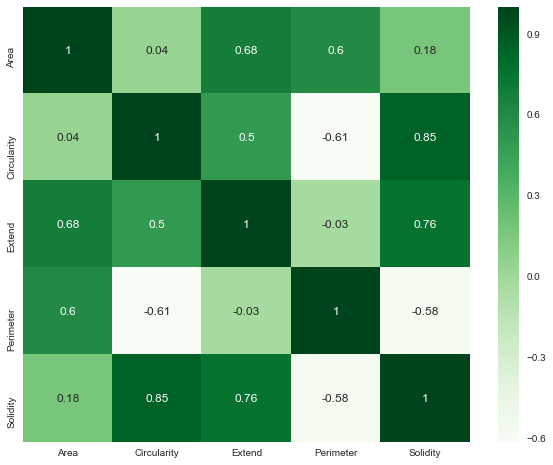

In [40]:
sns.set(rc={'figure.figsize':(10,8)})
sns.heatmap(
    corr, annot=True, cmap='Greens'
)

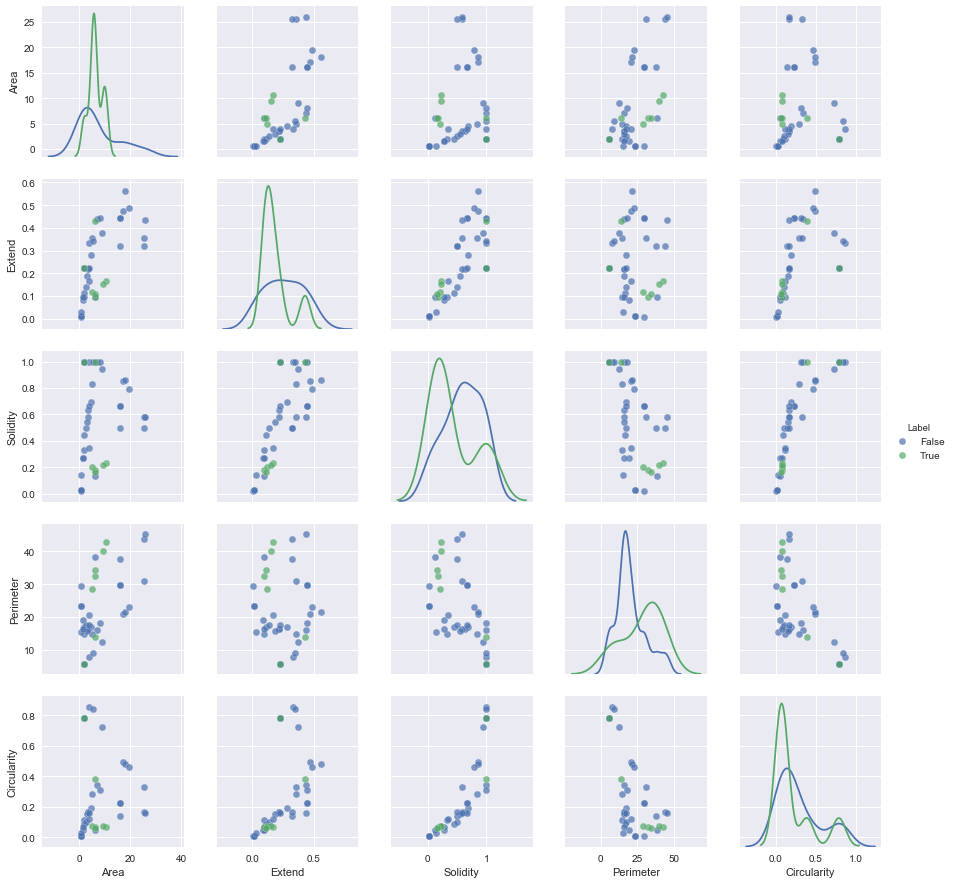

In [26]:
sns.pairplot(df, 
             vars=['Area', 'Extend', 'Solidity','Perimeter', 'Circularity'], 
             hue="Label",
             plot_kws=dict(alpha=0.7),
             diag_kind='kde'
    )

In [49]:
def filterCountour(extend, solidity, extend_range, solidity_range):
    e_min = min(extend_range)
    e_max = max(extend_range)
    s_min = min(solidity_range)
    s_max = max(solidity_range)
    if (e_min < extend < e_max and s_min < solidity < s_max):
        return True
    else:
        return False

In [50]:
extend_range = [0,0.5]
solidity_range = [0,0.5]

In [54]:
df['Prediction'] = df.apply(lambda x: filterCountour(x['Extend'], x['Solidity'], extend_range, solidity_range), axis=1)

In [58]:
report = classification_report(df['Label'], df['Prediction'])

In [59]:
report

'             precision    recall  f1-score   support\n\n      False       0.92      0.71      0.80        34\n       True       0.33      0.71      0.45         7\n\navg / total       0.82      0.71      0.74        41\n'

In [61]:
data = np.load('data/stemboks.npy')

In [104]:
data

array([{'name': 'Socialdemokratiet', 'rect': [(435, 172), (445, 163)]},
       {'name': 'Lis Tribler, Slagelse', 'rect': [(201, 192), (211, 184)]},
       {'name': 'Helle Blak, Slagelse', 'rect': [(201, 209), (210, 200)]},
       {'name': 'Jørgen Andersen, Korsør', 'rect': [(202, 225), (210, 217)]},
       {'name': 'Sten Olsen, Skælskør', 'rect': [(201, 242), (210, 233)]},
       {'name': 'Søren Horn Petersen, Slagelse', 'rect': [(202, 258), (210, 250)]},
       {'name': 'Niels Christian Nielsen, Skælskør', 'rect': [(201, 276), (210, 266)]},
       {'name': 'Bodil Knudsen, Slagelse', 'rect': [(201, 292), (210, 284)]},
       {'name': 'Britta Huntley, Korsør', 'rect': [(201, 307), (209, 300)]},
       {'name': 'Kurt Rasmussen, Slagelse', 'rect': [(201, 325), (211, 317)]},
       {'name': 'Jacob Borello Carlsen, Slagelse', 'rect': [(202, 343), (210, 334)]},
       {'name': 'Niels O. Pedersen, Gimlinge', 'rect': [(201, 359), (210, 350)]},
       {'name': 'Anders Nielsen, Korsør', 'rect': 

In [102]:
data[31]['name'] = 'Leon Johansen'

In [105]:
np.save('data/stemboks_corrected.npy', data)